##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [ ]:
# Use seaborn for pairplot. It should be already installed in colab.
# !pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values:

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [6]:
dataset = dataset.dropna()

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

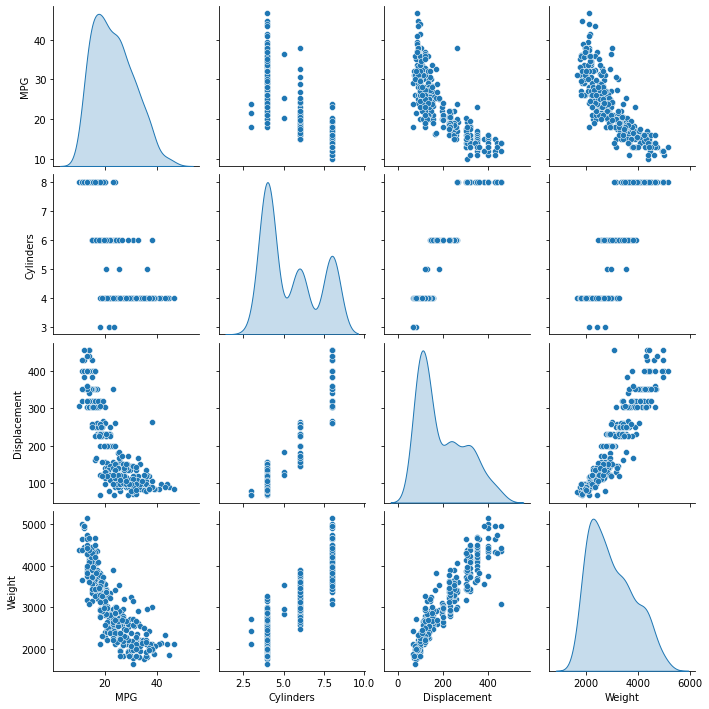

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Before linear regression (NCCU)

$M_1: \hat{y} = a x_1 +b $

How dose $M_1$ looks like by using "network structure"?


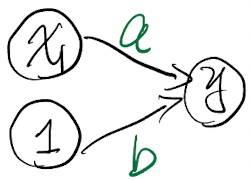

How about $M_2$?

$M_2: \hat{y} = w_0 + w_1 x_1 + w_2 x2 + \dots w_m x_m $



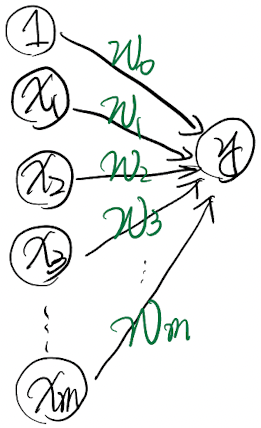

Do you believe that the real-world data is truly liner? How about adding some non-linear relation between $X$ and $y$?

$A()$ is a non-linear funciton (called **activation function**), for example, $\text{sigmoid}(z) = \sigma(z) = \frac{1}{1+e^{-z}}$

$M_3: \hat{y} = A(w_0 + w_1 x_1 + w_2 x2 + \dots w_m x_m)$ 

$M_3: \hat{y} = \sigma(W X), W = [w_0, w_1, \dots, w_m],  X = [1, x_1, x_2, \dots, x_m]$ 

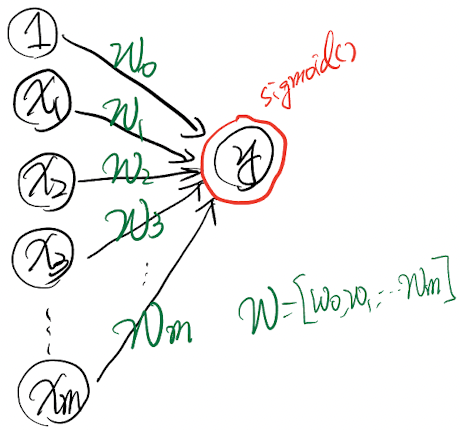

Do you believe that the real-world data is so simple? How about adding some layers between $X$ and $y$?

Each color (ands it corresponding node) represents a relation between 'nodes', a.k.a. neuron. You can say that we now have $k$ different 'point of view' to analyze the original $X$, and then we further use a non-linear relation to describe ($W_y$ and the last $\sigma$) the $k$'s viewpoints and $y$.

If $W = [W_1, W_2, \dots, W_m]$, the size of $W$ is $m \times k$.

$M_4: \hat{y} = \sigma(W_y \sigma(W X)) $ 

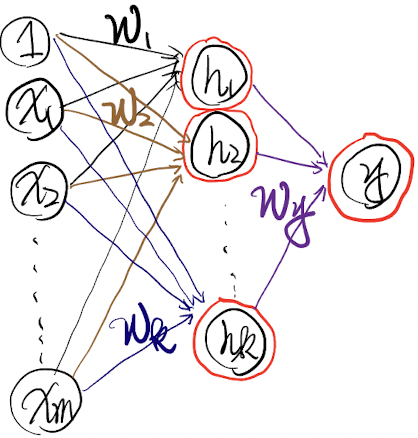

Further, you can design different number of layers and different number of neurons to construct your model of describing the relation between $X$ and $y$. The layer we used here is called **Dense**.

https://www.tensorflow.org/api_docs/python/tf/keras/layers

However, the math behind the neural network is similar to liner regression, i.e., we sitll calculate MSE to evaluation the difference between $y$ and $\hat{y}$. We still use partial differential to find the minmal value of MSE.

Question: can we remove the activation function?

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [14]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [15]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Is notmalization truly useful? (NCCU)

#### w/o normalization

In [17]:
# assume we use Horsepower to predict MPG
_df = train_dataset[['Horsepower', 'MPG']]
_df

,Horsepower,MPG
146,75.0,28.0
282,88.0,22.3
69,160.0,12.0
378,63.0,38.0
331,67.0,33.8
...,...,...
281,85.0,19.8
229,180.0,16.0
150,93.0,26.0
145,61.0,32.0


In [18]:
# try linear regression
# without normalization
x = train_dataset.Horsepower
y = train_dataset.MPG

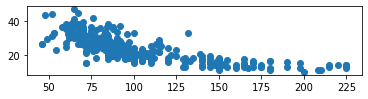

In [19]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(_df.Horsepower, _df.MPG)
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))
linear_b0 = linear.intercept_[0]
linear_b1 = linear.coef_[0][0]
print("linear:", linear_b0, linear_b1)

linear: 39.57626034041162 -0.15510479355246892


In [21]:
def mse(b0, b1, x, y):
    mse = 0
    for xi,yi in zip(x,y):
        mse += xi*xi*b1*b1 + b0*b0 + 2*xi*b1*b0 -2*xi*yi*b1 - 2*yi*b0 + yi*yi
    mse = mse/(2*len(x)) # use 1/2n version
    return mse 

$\text{MSE} = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y_i})^{2}$

$\hat{y_i} = \theta_0 + \theta_1 x_i$

$\text{MSE} = \frac{1}{2n}\sum_{i=1}^{n}{x_{i}^{2}\theta_{1}^{2} + \theta_{0}^{2} + 2 x_i \theta_1 \theta_0 - 2 x_{i} y_{i} \theta_1 - 2 y_i \theta_0  + y_{i}^{2} }$

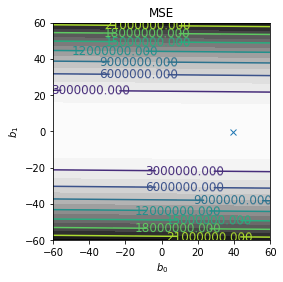

In [22]:
# mesh
grid = 100
b0_range = np.linspace(-60, 60, grid) 
b1_range = np.linspace(-60, 60, grid) 
B0, B1 = np.meshgrid(b0_range, b1_range) 

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# contour
plt.contourf(B0, B1, mse(B0, B1, x, y), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, mse(B0, B1, x, y)) # line
plt.clabel(C, inline=True, fontsize=12)

# point
plt.plot([linear_b0],[linear_b1], 'x')

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('MSE')
plt.show()

#### w/ normalization

In [23]:
# try linear regression
# with normalization
x = train_dataset.Horsepower
y = train_dataset.MPG

# https://scikit-learn.org/stable/modules/preprocessing.html
# Try other preprocessing !!!!
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(np.array(x).reshape(-1, 1))

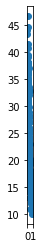

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(x_scaled, _df.MPG)
plt.show()

In [25]:
linear_scaled = LinearRegression()
linear_scaled.fit(x_scaled, np.array(y).reshape(-1, 1))
linear_scaled_b0 = linear_scaled.intercept_[0]
linear_scaled_b1 = linear_scaled.coef_[0][0]
print("linear scaled:", linear_scaled_b0, linear_scaled_b1)

linear scaled: 32.44143983699806 -27.763758045891937


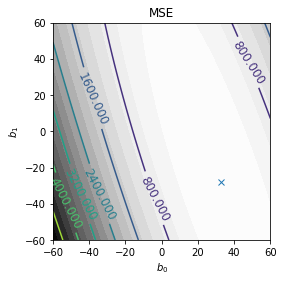

In [26]:
# mesh
grid = 100
b0_range = np.linspace(-60, 60, grid) 
b1_range = np.linspace(-60, 60, grid) 
B0, B1 = np.meshgrid(b0_range, b1_range) 

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
# contour
plt.contourf(B0, B1, mse(B0, B1, x_scaled, y), levels = 20, cmap=plt.cm.Greys) # map
C = plt.contour(B0, B1, mse(B0, B1, x_scaled, y)) # line
plt.clabel(C, inline=True, fontsize=12)

# point
plt.plot([linear_scaled_b0],[linear_scaled_b1], 'x')

plt.xlabel('$b_0$')
plt.ylabel('$b_1$')
plt.title('MSE')
plt.show()

Again, is normalization truly useful?

Normalized data allows faster convergence!

Does the 'target' need to be normalized?

What is 'softmax activation function'?

$\text{MSE} = \frac{1}{2n}\sum_{i=1}^{n}{x_{i}^{2}\theta_{1}^{2} + \theta_{0}^{2} + 2 x_i \theta_1 \theta_0 - 2 x_{i} y_{i} \theta_1 - 2 y_i \theta_0  + y_{i}^{2} }$

If 314 original data points are used,

$\text{MSE} = \frac{1}{2 * 314} 3907509 \theta_1^2 + \theta_{0}^{2} + 2 * 32929 \theta_1 \theta_0 - 2 * 697133.29 \theta_1 - 2 * 7319.49 \theta_0 + 189317.41$.

If 314 **scaled** data points are used,

$\text{MSE} = \frac{1}{2 * 314} 48.14 \theta_1^2 + \theta_{0}^{2} + 2 * 103.27 \theta_1 \theta_0 - 2 * 2013.61 \theta_1 - 2 * 7319.49 \theta_0 + 189317.41$.

$\theta_{i}^{(t+1)} = \theta_{i}^{(t)} - \gamma \frac{\partial \text{MSE}(\theta)}{\partial \theta_i}$

* $x_i$ is in the gradient descent formula, which means the value of $x_i$ determines the update rate. Therefore, a larger $x_i$ will lead to a greater leap in the gradient landscape. Meanwhile, a larger $x_i$ leads to smaller $\theta$, when given $y_i$.

* When $x_i$ is large, the distance between the initial $\theta$ (which is randomly picked) and the global minimum MSE is very likely to be small. Therefore, the algorithm is more likely to fail when $x_i$ is larger (learning rate is fixed) because the algorithm makes giant leaps toward the very close target $\theta^{*}$ while baby steps are needed.

## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = ax+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


(NCCU) notice: The above model looks like

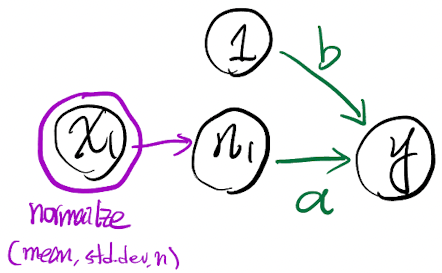

Hint: the normalization layer is simply a preprocessing. It has no trainable variables. The three parameters are simply mean, std. dev, and the number of training data points, calculated from training dataset.

This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [ ]:
horsepower_model.predict(horsepower[:10])

array([[ 1.005],
       [ 0.568],
       [-1.855],
       [ 1.409],
       [ 1.274],
       [ 0.5  ],
       [ 1.51 ],
       [ 1.274],
       [ 0.332],
       [ 0.568]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [ ]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#### Discussion of model compile (NCCU)

Notice: this example uses MAE as the loss function.

$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y - \hat{y} | $

See how many loss functions are provided in tensorflow.

https://www.tensorflow.org/api_docs/python/tf/keras/losses

Then, see how optimizers works.

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer

You MUST see this! The explaination of different optimizers.

https://ruder.io/optimizing-gradient-descent/


Use Keras `Model.fit` to execute the training for 100 epochs:

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.08 s, sys: 159 ms, total: 5.24 s
Wall time: 7.63 s


#### Discussion of model fit (NCCU)

'Epoch' means how many times you want your all data points to be went through.

'Validation' means how many data points you want to save for the early stop. These validation data points will not be used for training the model parameters.

Visualize the model's training progress using the stats stored in the 'history` object:




In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804142,4.187665,95
96,3.804466,4.188651,96
97,3.802012,4.191092,97
98,3.807920,4.200649,98
99,3.801208,4.183963,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

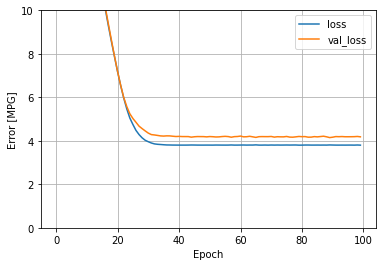

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

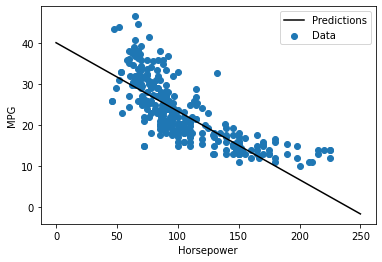

In [ ]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = ax+b$ except that $a$ is a matrix and $b$ is a vector. Or we often represent it as $y = \theta x + b$ or $y = WX$.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [ ]:
linear_model.predict(train_features[:10])

array([[-0.787],
       [-1.045],
       [ 1.279],
       [-2.307],
       [-1.877],
       [-1.165],
       [-2.127],
       [ 1.421],
       [-0.466],
       [-0.357]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $\theta$ in $y=\theta X+b$) have a shape of `(9, 1)`:

In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.452],
       [-0.002],
       [ 0.535],
       [ 0.565],
       [-0.113],
       [-0.616],
       [ 0.604],
       [-0.452],
       [-0.627]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.93 s, sys: 164 ms, total: 5.1 s
Wall time: 7.55 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

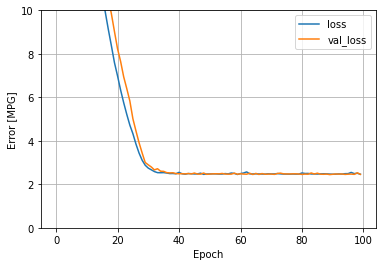

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Before DNN (NCCU)

Linear may not be good enough to describe the real-world relation.

How about adding some activation function on the nodes?

https://www.tensorflow.org/api_docs/python/tf/keras/activations

https://en.wikipedia.org/wiki/Activation_function

How a activation funcation looks like?

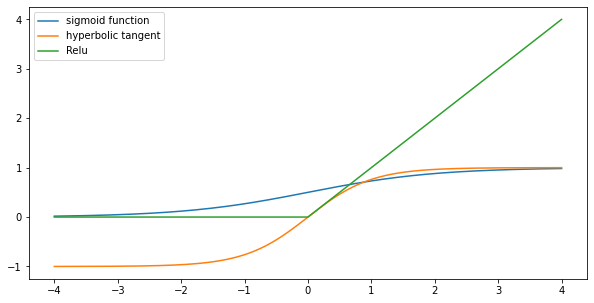

In [ ]:
x = np.linspace(-4, 4, 1000)
y1 = 1 / (1 + np.exp(-x) )
y2 = ( 2 / (1 + np.exp(-2*x) ) ) -1
y3 = np.maximum(0, x)

plt.figure(figsize=(10, 5))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(['sigmoid function', 'hyperbolic tangent', 'Relu'])
plt.show()

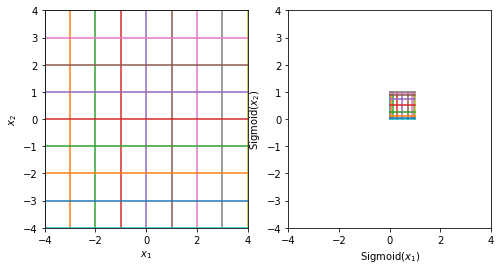

In [ ]:
from scipy.special import expit

lim = 4
span = 1
_x = np.linspace(-1*lim, lim, 1000)
_y = np.linspace(-1*lim, lim, 1000)

xs = [np.linspace(i, i, 1000) for i in range(-1*lim, lim+1, span)]
ys = [np.linspace(i, i, 1000) for i in range(-1*lim, lim+1, span)]

fig= plt.figure(figsize=(4 *2, 4))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)

for x in xs:
  ax_1.plot(x, _y)
  ax_2.plot(expit(x), expit(_y))
for y in ys:
  ax_1.plot(_x, y)
  ax_2.plot(expit(_x), expit(y))

ax_1.set_xlim(-1*lim, lim)
ax_1.set_ylim(-1*lim, lim)
ax_2.set_xlim(-1*lim, lim)
ax_2.set_ylim(-1*lim, lim)
ax_1.set_xlabel("$x_1$")
ax_1.set_ylabel("$x_2$")
ax_2.set_xlabel("Sigmoid($x_1$)")
ax_2.set_ylabel("Sigmoid($x_2$)")

plt.show()

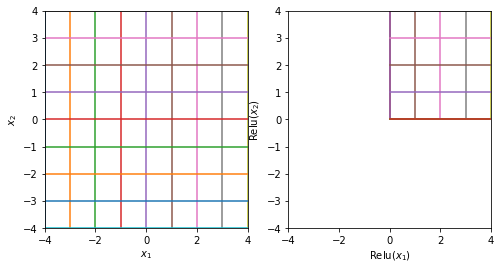

In [ ]:
fig= plt.figure(figsize=(4 *2, 4))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)

def relu(x):
  return np.maximum(0, x)

for x in xs:
  ax_1.plot(x, _y)
  ax_2.plot(relu(x), relu(_y))
for y in ys:
  ax_1.plot(_x, y)
  ax_2.plot(relu(_x), relu(y))

ax_1.set_xlim(-1*lim, lim)
ax_1.set_ylim(-1*lim, lim)
ax_2.set_xlim(-1*lim, lim)
ax_2.set_ylim(-1*lim, lim)
ax_1.set_xlabel("$x_1$")
ax_1.set_ylabel("$x_2$")
ax_2.set_xlabel("Relu($x_1$)")
ax_2.set_ylabel("Relu($x_2$)")

plt.show()

How do mulitple layers look like?

In [ ]:
def build_and_compile_onelayer_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(12, activation='relu', kernel_initializer='random_uniform'),
      layers.Dense(1)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
x = tf.linspace(0.0, 250, 251)
dnn_horsepower_onelayer_model = build_and_compile_onelayer_model(horsepower_normalizer)

In [ ]:
dnn_horsepower_onelayer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 12)                24        
                                                                 
 dense_3 (Dense)             (None, 1)                 13        
                                                                 
Total params: 40
Trainable params: 37
Non-trainable params: 3
_________________________________________________________________


In [ ]:
dnn_horsepower_onelayer_model.fit(
    train_features['Horsepower'],
    train_labels,
#    validation_split=0.2,
    verbose=0, epochs=100)
y = dnn_horsepower_onelayer_model.predict(x)

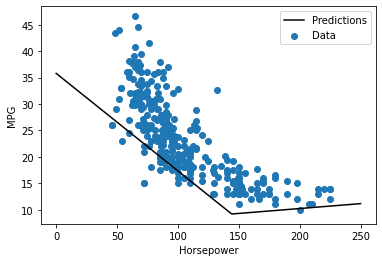

In [ ]:
plot_horsepower(x, y)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                128       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.49 s, sys: 222 ms, total: 5.71 s
Wall time: 11.2 s


This model does slightly better than the linear single-input `horsepower_model`:

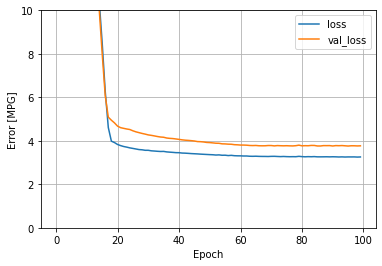

In [ ]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

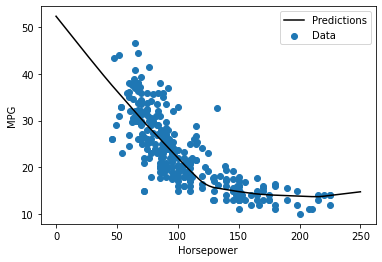

In [ ]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_7 (Dense)             (None, 64)                640       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.09 s, sys: 209 ms, total: 4.3 s
Wall time: 3.82 s


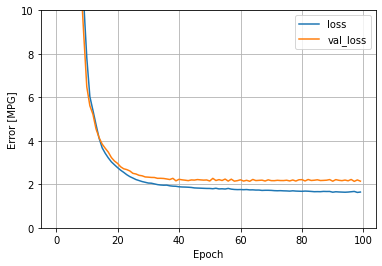

In [ ]:
plot_loss(history)

Collect the results on the test set:

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.644516
linear_model,2.471452
dnn_horsepower_model,2.913158
dnn_model,1.729802


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

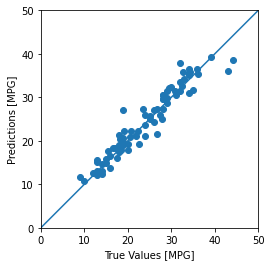

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

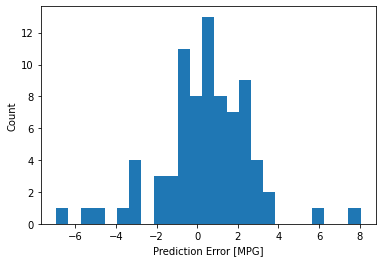

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.644516
linear_model,2.471452
dnn_horsepower_model,2.913158
dnn_model,1.729802
reloaded,1.729802


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

## A more complex 2d-2d example (NCCU)



### Data

In [ ]:
data_df = pd.read_csv('https://drive.google.com/uc?id=1vDttaEz5Kv2UMPAH__c323RkWH-5iOsU')

Y = data_df['target'] = data_df.Class == 'C1'
X = data_df[['x','y']]
data_df = data_df[['x','y','target']]
data_df

,x,y,target
0,-0.835136,1.504211,False
1,-0.941413,1.345666,False
2,-1.514424,1.102896,False
3,-1.751756,0.733600,False
4,-1.897773,0.077230,False
...,...,...,...
445,0.654502,-0.543979,True
446,0.406611,-0.318900,True
447,0.204583,-0.507917,True
448,0.153848,-0.075671,True


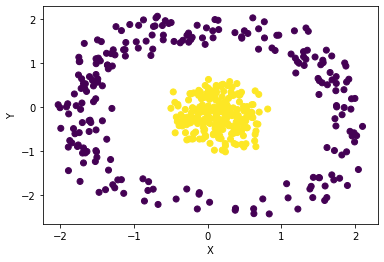

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

xs = data_df['x']
ys = data_df['y']
zs = data_df['target']
ax.scatter(xs, ys, c=zs)

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

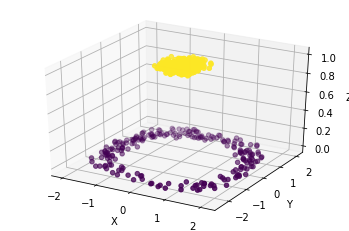

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = data_df['x']
ys = data_df['y']
zs = data_df['target']
ax.scatter(xs, ys, zs, c=zs)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### NN

In [ ]:
def two2two_model():
  model = keras.Sequential([
      layers.Dense(3, name='L1'),
      layers.Activation('relu', name="L2"),
      layers.Dense(3, name='L3'),
      layers.Activation('relu', name="L4"),
      layers.Dense(3, name='L5'),
      layers.Activation('relu', name="L6"),

      layers.Dense(1, name="Last")
  ])

  model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = ['acc'])
  return model
t2t_model = two2two_model()

In [ ]:
%%time
history = t2t_model.fit(
    X,
    Y,
    validation_split=0.1,
    verbose=0, epochs=200)

CPU times: user 9.15 s, sys: 430 ms, total: 9.58 s
Wall time: 10.8 s


In [ ]:
t2t_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 3)                 9         
                                                                 
 L2 (Activation)             (None, 3)                 0         
                                                                 
 L3 (Dense)                  (None, 3)                 12        
                                                                 
 L4 (Activation)             (None, 3)                 0         
                                                                 
 L5 (Dense)                  (None, 3)                 12        
                                                                 
 L6 (Activation)             (None, 3)                 0         
                                                                 
 Last (Dense)                (None, 1)                

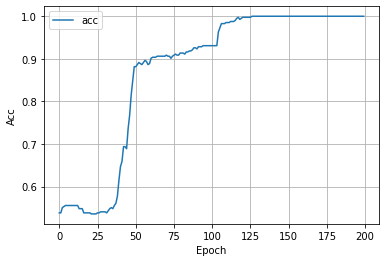

In [ ]:
def plot_acc(history):
  plt.plot(history.history['acc'], label='acc')
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend()
  plt.grid(True)

plot_acc(history)

In [ ]:
t2t_model.weights

[<tf.Variable 'L1/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[-0.692, -0.246, -0.659],
        [-1.032,  0.555,  0.084]], dtype=float32)>,
 <tf.Variable 'L1/bias:0' shape=(3,) dtype=float32, numpy=array([-0.147,  0.157,  1.057], dtype=float32)>,
 <tf.Variable 'L3/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.607, -0.092,  0.621],
        [-0.992, -0.987,  0.653],
        [ 1.068,  0.981,  0.25 ]], dtype=float32)>,
 <tf.Variable 'L3/bias:0' shape=(3,) dtype=float32, numpy=array([-0.013,  0.02 , -0.495], dtype=float32)>,
 <tf.Variable 'L5/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.005,  0.213,  0.033],
        [-0.34 ,  0.779,  0.558],
        [-0.826, -1.962, -0.956]], dtype=float32)>,
 <tf.Variable 'L5/bias:0' shape=(3,) dtype=float32, numpy=array([ 0.   ,  0.008, -0.013], dtype=float32)>,
 <tf.Variable 'Last/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-1.016],
        [ 1.399],
        [ 1.126]], dtype=float32)>,
 <tf.Variable 'Last/bias:0'

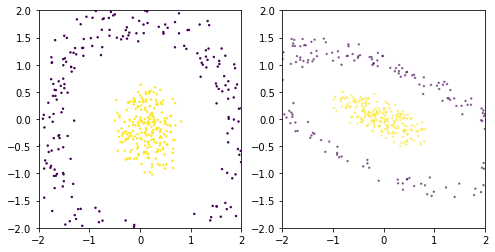

In [ ]:
def plot_layer(layer_name, _X):
  global xs, ys, zs

  _model = tf.keras.Model(
      inputs = t2t_model.input,
      outputs = t2t_model.get_layer(layer_name).output)
  _output = _model.predict(_X)

  lim = 2
  fig= plt.figure(figsize=(4 *2, 4))
  ax_1 = fig.add_subplot(121)
  ax_2 = fig.add_subplot(122)

  ax_1.scatter(xs, ys, c=zs, s=2)
  ax_2.scatter(_output[:,0], _output[:,1], c=zs, s = 2, alpha=.5)

  ax_1.set_xlim(-1*lim, lim)
  ax_1.set_ylim(-1*lim, lim)
  ax_2.set_xlim(-1*lim, lim)
  ax_2.set_ylim(-1*lim, lim)
  plt.show()

plot_layer("L1", X)

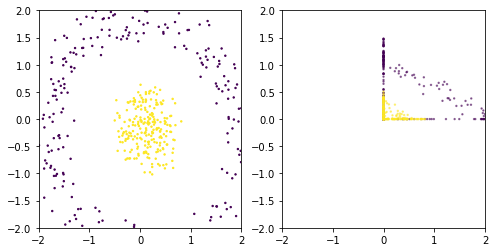

In [ ]:
plot_layer("L2", X)

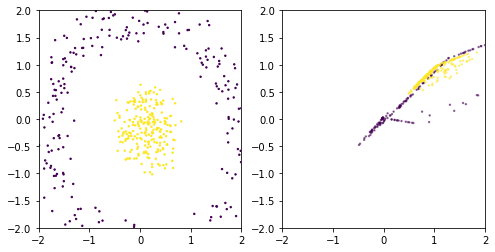

In [ ]:
plot_layer("L3", X)

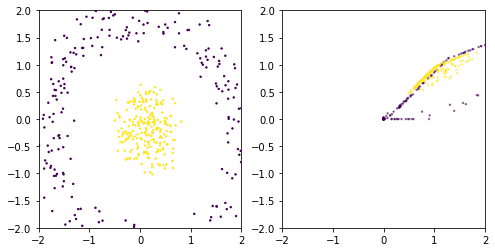

In [ ]:
plot_layer("L4", X)

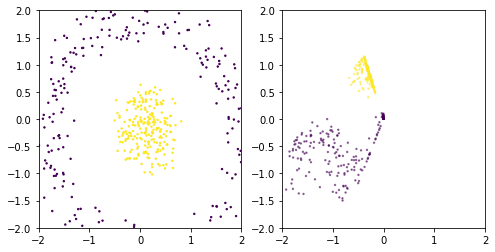

In [ ]:
plot_layer("L5", X)

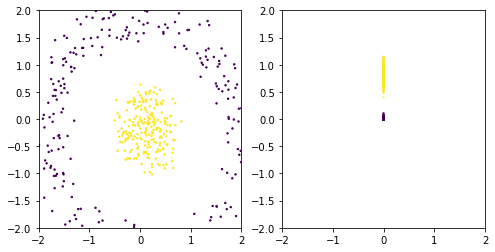

In [ ]:
plot_layer("L6", X)

## A more and more complex example (NCCU)

$z = F(x,y) = 2 \log_2 (x^2 + y^2 + 0.2) + 2$

https://medium.com/analytics-vidhya/how-does-relu-activation-work-part-2-8bb4feeb3b42